<a href="https://colab.research.google.com/github/fisterfolks/NTI/blob/master/LAB2videopotoki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#downloading gcsfuse
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

#Mounting Raw folder
!mkdir raw
!gcsfuse -o nonempty raw-images-dng-storage /content/raw 

#Mounting tiff folder
!mkdir tiff
!gcsfuse -o nonempty expert-c-images-tiff /content/tiff 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  19205      0 --:--:-- --:--:-- --:--:-- 19787
OK
70 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.28.1).
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.
mkdir: cannot create directory ‘raw’: File exists
Using mount point: /content/raw
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
mkdir: cannot create directory ‘tiff’: File exists
Using mount point: /content/tiff
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [30]:
import glob
tif_images = glob.glob('/content/tiff/*')
raw_images = glob.glob('/content/raw/*')
print(len(tif_images))
print(len(raw_images))

998
998


In [31]:
print(tif_images[:10])
print(raw_images[:10])


['/content/tiff/a0001-jmac_DSC1459.tif', '/content/tiff/a0002-dgw_005.tif', '/content/tiff/a0003-NKIM_MG_8178.tif', '/content/tiff/a0004-jmac_MG_1384.tif', '/content/tiff/a0005-jn_2007_05_10__564.tif', '/content/tiff/a0006-IMG_2787.tif', '/content/tiff/a0007-IMG_2480.tif', '/content/tiff/a0008-WP_CRW_3959.tif', '/content/tiff/a0009-kme_372.tif', '/content/tiff/a0010-jmac_MG_4807.tif']
['/content/raw/a0001-jmac_DSC1459.dng', '/content/raw/a0002-dgw_005.dng', '/content/raw/a0003-NKIM_MG_8178.dng', '/content/raw/a0004-jmac_MG_1384.dng', '/content/raw/a0005-jn_2007_05_10__564.dng', '/content/raw/a0006-IMG_2787.dng', '/content/raw/a0007-IMG_2480.dng', '/content/raw/a0008-WP_CRW_3959.dng', '/content/raw/a0009-kme_372.dng', '/content/raw/a0010-jmac_MG_4807.dng']


In [32]:
# Let's view an image
import glob
import numpy as np
import matplotlib.pyplot as plt
tif_images = glob.glob('/content/tiff/*')
raw_images = glob.glob('/content/raw/*')
print(len(tif_images))
print(len(raw_images))


998
998


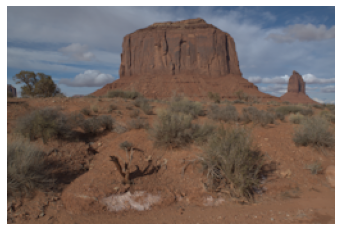

In [33]:
image = plt.imread(raw_images[0])
plt.axis(False)
plt.imshow(image);

In [0]:
X = raw_images
y = tif_images

In [0]:
NUM_IMAGES = 900 #@param {type:"slider", min:100, max:1000,step:100}

In [36]:
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.001,
                                                  random_state=0)
len(X_train), len(y_train), len(X_val), len(y_val)

(899, 899, 1, 1)

In [37]:
!sudo apt-get install -y exiftool

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
libimage-exiftool-perl is already the newest version (10.80-1).
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.


In [38]:
!pip install rawpy
!pip install pyexifinfo

In [0]:
import subprocess
import os
import json
from skimage.util import img_as_float
from skimage import io
import rawpy
from skimage.measure import compare_psnr, compare_ssim
import json
import pyexifinfo as p

In [0]:
from tensorflow.keras.utils import Sequence
path_to_dng = '/content/raw/'
path_to_tiff = '/content/tiff/'


In [41]:
import tensorflow as tf
print("TF version:", tf.__version__)
# Check for GPU availability
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "Not Available")


TF version: 2.2.0
GPU Not Available


In [0]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Input, Add, Activation, AveragePooling2D, ZeroPadding2D, Conv2DTranspose, concatenate
# Glorot uniform initializer, also called Xavier uniform initializer.
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

![alt text](https://docs.fast.ai/imgs/u-net-architecture.png)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [0]:
def get_unet(pretrained_model = "", input_img= (256, 256), n_filters = 16, batchnorm = True):
    # Contracting Path
    if os.path.exists(pretrained_model):
        model = load_model(pretrained_model, custom_objects={'PSNR': PSNR})
    else:
        inputs = Input(input_img)
        print(inputs.shape)
        c1 = conv2d_block(inputs, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        p1 = MaxPooling2D((2, 2))(c1)
        
        c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        p2 = MaxPooling2D((2, 2))(c2)
        
        c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        p3 = MaxPooling2D((2, 2))(c3)
        
        c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        p4 = MaxPooling2D((2, 2))(c4)
        
        c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
        
        # Expansive Path
        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
        u6 = concatenate([u6, c4])
        c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
        
        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
        u7 = concatenate([u7, c3])
        c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
        
        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
        u8 = concatenate([u8, c2])
        c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
        
        u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
        u9 = concatenate([u9, c1])
        c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
        
        outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
        model = Model(inputs=inputs, outputs=[outputs])
    return model

In [0]:
def save_model(nameofvolume, model, folder, suffix=None):
    modeldir = os.path.join(f"{folder}")
    model_path = modeldir + nameofvolume + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

In [0]:
def show_images(image1, image2):
  fig=plt.figure(figsize=(24, 6))
  fig.add_subplot(1, 2, 1)
  plt.title('X')
  plt.axis("off")
  plt.imshow(image1)
  fig.add_subplot(1, 2, 2)
  plt.title('Y')
  plt.axis("off")
  plt.imshow(image2)

In [0]:
def show_image(image):
  # fig=plt.figure(figsize=(24, 6))
  # fig.add_subplot(1, 2, 1)
  plt.title('image')
  plt.axis("off")
  plt.imshow(image)

In [0]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_raw, list_tif, batch_size=32, n_channels=1, window_size=512,
                 n_classes=3,debug=False):
        'Initialization'
        self.batch_size = batch_size
        self.window_size=window_size
        self.list_raw = list_raw
        self.list_tif = list_tif
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.on_epoch_end()
        self.debug = debug

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_raw) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*int(self.batch_size*4):(index+1)*int(self.batch_size*4)]
        X, y = self.__data_generation(self.list_raw)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_raw))

    def process_dng(self, dng_name):
        metadata = str(subprocess.check_output(
            ["exiftool", dng_name, "-Orientation", "-BitsPerSample", "-DefaultCropOrigin", "-DefaultCropSize"]))
        raw = rawpy.imread(dng_name)
        dng = raw.raw_image_visible  # matrix bayer
        metadata = str(metadata).split('\\n') # on local machine maybe need '\\r\\n'
        metadata = metadata[0:(len(metadata) - 1)]
        data = []
        for row in metadata:
            data.append(row.split(': ')[1])
        bits = int(data[1])
        x_crop = int(data[2].split()[0].split('.')[0])
        y_crop = int(data[2].split()[1].split('.')[0])
        W_im = int(data[3].split()[0])
        H_im = int(data[3].split()[1])

        H_im = int(H_im / 8) * 8
        W_im = int(W_im / 8) * 8
        #best idea for optimize is use only photos with horizontally(normal) orientation
        if data[0] == "Rotate 90 CW":
            dng = np.rot90(dng, 3)
            x_crop, y_crop = y_crop, x_crop
            W_im, H_im = H_im, W_im
        elif data[0] == "Rotate 270 CW":
            dng = np.rot90(dng)
            x_crop, y_crop = y_crop, x_crop
            W_im, H_im = H_im, W_im
        elif data[0] == "Rotate 180":
            dng = np.rot90(dng, 2)
        dng = dng[y_crop:y_crop + H_im, x_crop:x_crop + W_im]
        image = dng / np.max(dng)
        return image

    def convert_image_to_array(self, ID):
        imagename = self.list_raw[ID]
        dng = self.process_dng(imagename)
        imagename = self.list_tif[ID]
        tif = cv2.imread(imagename)
        tif = tif[:dng.shape[0], :dng.shape[1], :] / 255
        return dng, tif

    def __data_generation(self, raw_dir):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.window_size, self.window_size), dtype=float)
        Y = np.empty((self.batch_size, self.window_size, self.window_size, self.n_classes), dtype=float)
        for i, ID in enumerate(raw_dir):
            try:
                dng, tif = self.convert_image_to_array(i)
                #1 batch = 1 crop
                rand_H = np.random.randint(len(dng) - self.window_size - 10)
                rand_W = np.random.randint(len(dng[0]) - self.window_size - 10)
                # Store sample
                #random crops from image
                X[i,] = (dng[(rand_H):(rand_H + self.window_size), (rand_W):(rand_W + self.window_size)])
                Y[i,] = (tif[(rand_H):(rand_H + self.window_size), (rand_W):(rand_W + self.window_size), :])

                if i == (self.batch_size - 1):
                    break
            except Exception as e:
                i -= 1
                print(e)
                continue

        if self.debug:
            print(X.shape)
        X = np.expand_dims(X, -1)
        
        return X, Y

In [0]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

In [0]:
params = {'batch_size': 16,
          'n_classes': 3,
          'n_channels': 1,
          'window_size' : 256,
          'debug': False}

gen_train = DataGenerator(X_train, y_train, **params)

In [102]:
model5 = get_unet(input_img=(None, None, 1))
model5.summary()

(None, None, None, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, None, None, 1 160         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, None, None, 1 64          conv2d_100[0][0]                 
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 1 0           batch_normalization_93[0][0]     
______________________________________________________________________

In [0]:
import math, cv2

In [0]:
checkpoint_filepath='/content/drive/My Drive/chekpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='train_loss',
    mode='max',
    save_best_only=False)
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=[PSNR])
historyAboutModel = model.fit(x=gen_train, epochs=10, callbacks =[model_checkpoint_callback])

Epoch 1/10
56/56 [==============================] - 1247s 22s/step - loss: 0.1127 - PSNR: 20.4155
Epoch 2/10
56/56 [==============================] - 1254s 22s/step - loss: 0.1161 - PSNR: 20.3038
Epoch 3/10
56/56 [==============================] - 1264s 23s/step - loss: 0.1162 - PSNR: 20.3717
Epoch 4/10
56/56 [==============================] - 1259s 22s/step - loss: 0.1140 - PSNR: 20.5517
Epoch 5/10
56/56 [==============================] - 1271s 23s/step - loss: 0.1129 - PSNR: 20.6145
Epoch 6/10
56/56 [==============================] - 1257s 22s/step - loss: 0.1094 - PSNR: 20.8813
Epoch 7/10
56/56 [==============================] - 1254s 22s/step - loss: 0.1161 - PSNR: 20.5021
Epoch 8/10
56/56 [==============================] - 1268s 23s/step - loss: 0.1148 - PSNR: 20.4762
Epoch 9/10
56/56 [==============================] - 1260s 22s/step - loss: 0.1137 - PSNR: 20.6799
Epoch 10/10
39/56 [===================>..........] - ETA: 6:20 - loss: 0.1081 - PSNR: 21.1837

![alt text](https://sun9-38.userapi.com/noiZNUmdlDbNSClJYJHAKO-Vaypoxd77k9_U9g/HieuJMIjTS0.jpg)

![alt text](https://sun9-17.userapi.com/PzX83R9xgfwa1I_qQIP6XEOFYUaEmXkIOPji5Q/AL7hI_3drIg.jpg)

In [0]:
model = load_model('/content/drive/My Drive/full-mse-60-epoch.h5', custom_objects={'PSNR':PSNR})

In [0]:
#save_model("30epochMaeSGD_vol3", model, '/content/drive/My Drive/')

In [0]:
def dng_preprocess_predict(dng_name):
        metadata = str(subprocess.check_output(
            ["exiftool", dng_name, "-Orientation", "-BitsPerSample", "-DefaultCropOrigin", "-DefaultCropSize"]))
        raw = rawpy.imread(dng_name)
        dng = raw.raw_image_visible  # matrix bayer
        metadata = str(metadata).split('\\n')
        metadata = metadata[0:(len(metadata) - 1)]
        data = []
        for row in metadata:
            data.append(row.split(': ')[1])
        bits = int(data[1])
        x_crop = int(data[2].split()[0].split('.')[0])
        y_crop = int(data[2].split()[1].split('.')[0])
        W_im = int(data[3].split()[0])
        H_im = int(data[3].split()[1])

        H_im = int(H_im / 8) * 8
        W_im = int(W_im / 8) * 8
        if data[0] == "Rotate 90 CW":
            dng = np.rot90(dng, 3)
            x_crop, y_crop = y_crop, x_crop
            W_im, H_im = H_im, W_im
        elif data[0] == "Rotate 270 CW":
            dng = np.rot90(dng)
            x_crop, y_crop = y_crop, x_crop
            W_im, H_im = H_im, W_im
        elif data[0] == "Rotate 180":
            dng = np.rot90(dng, 2)
        dng = dng[y_crop:y_crop + H_im, x_crop:x_crop + W_im]
        image = dng / np.max(dng)
        return image

In [0]:
def predict_image(filename1, filename2, model):
    imgafterdng = dng_preprocess_predict(filename1)
    print(f'{imgafterdng.shape[0]}x{imgafterdng.shape[1]}')
    img_shape = imgafterdng.shape
    center_x = math.floor(img_shape[0]/2)
    center_y = math.floor(img_shape[1]/2)
    size = 256
    raw_image_center = imgafterdng[center_x - size:center_x + size, center_y - size:center_y + size]
    show_image(raw_image_center)
    im = cv2.imread(filename2)
    tif_image_center = im[center_x - size:center_x + size, center_y - size:center_y + size, :]
    show_images(raw_image_center,tif_image_center)
    raw_image_center = np.expand_dims(raw_image_center, 0)
    y_pred = model.predict(raw_image_center)
    y_pred = np.clip(y_pred * 256, 0, 255)
    y_pred = y_pred.astype(int)
    print(calculate_psnr(y_pred[0], tif_image_center))
    show_images(y_pred[0], tif_image_center)

4032x6048
15.696809963731631


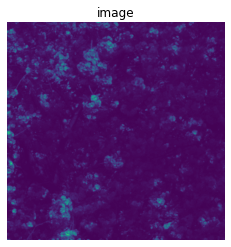

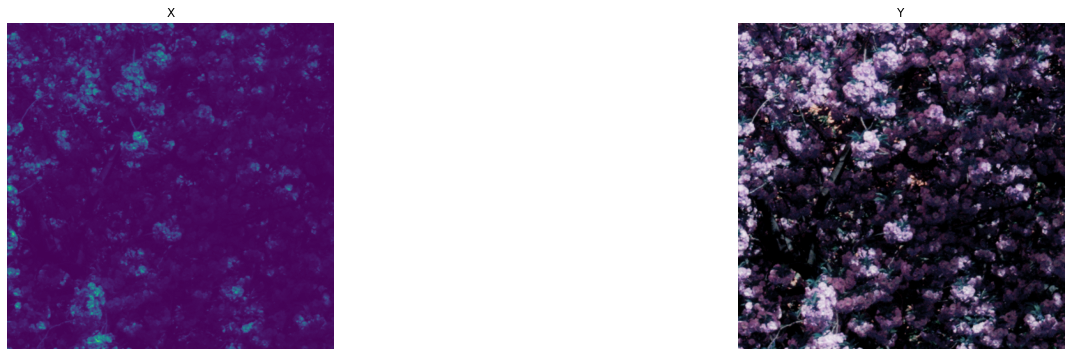

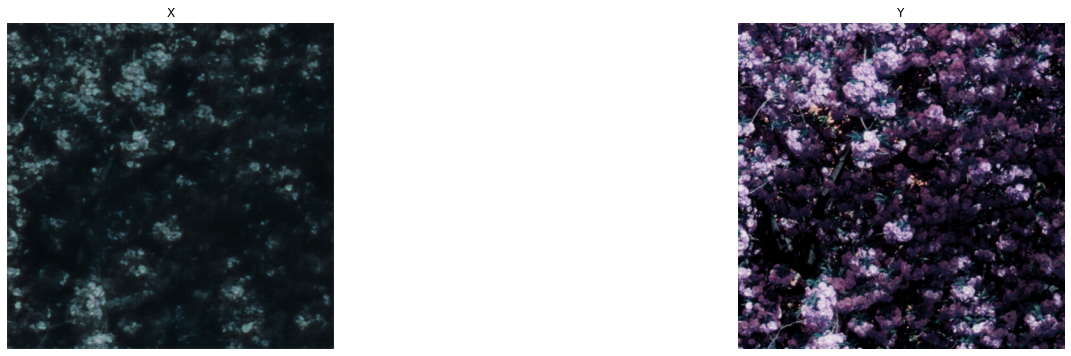

In [57]:
predict_image(raw_images[-1], tif_images[-1], model)

3872x2592
19.10360460212654


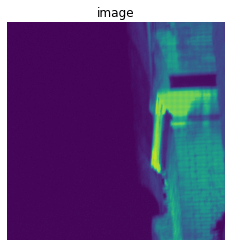

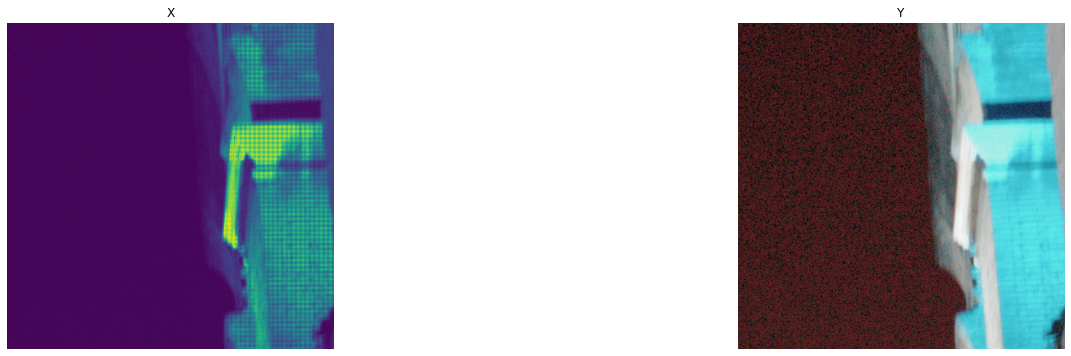

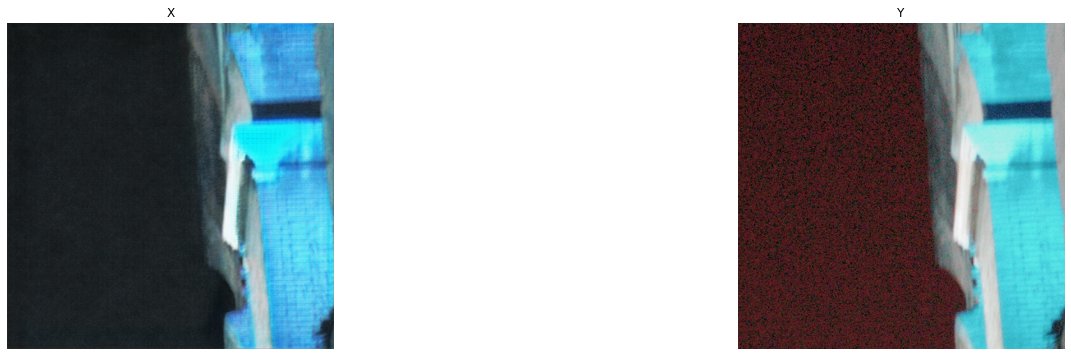

In [58]:
predict_image(raw_images[-2], tif_images[-2], model)

6048x4032
23.642813801634652


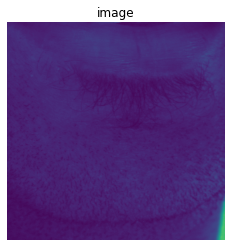

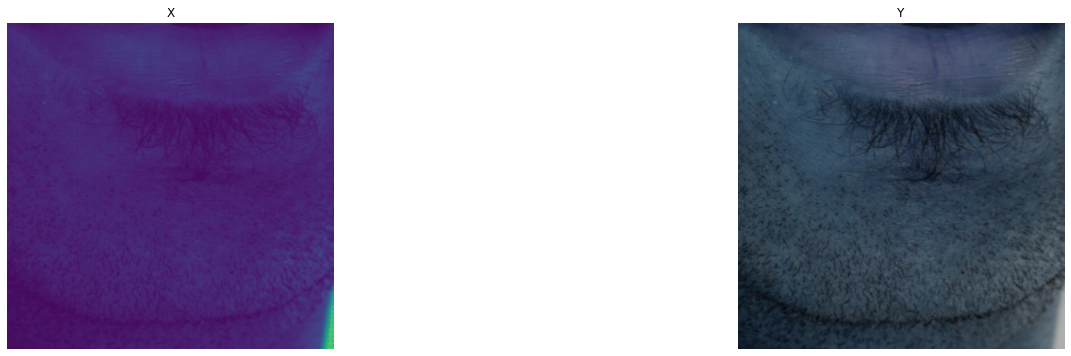

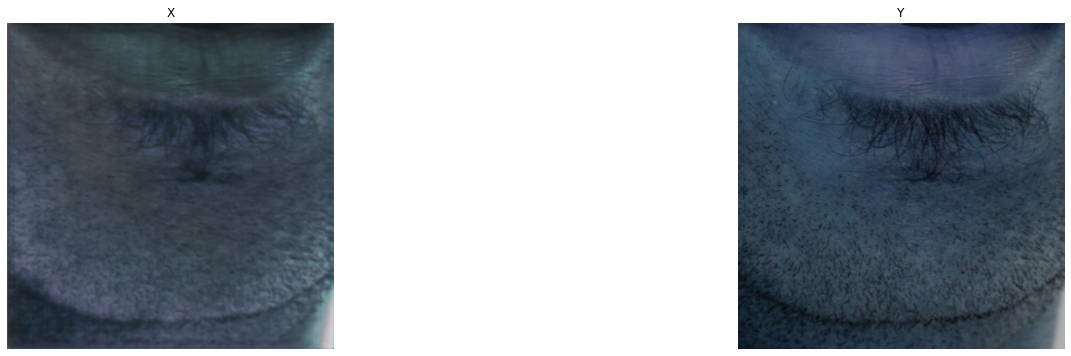

In [59]:
predict_image(raw_images[-4], tif_images[-4], model)

In [132]:
model5.compile(optimizer='sgd', loss='mean_absolute_error', metrics=[PSNR])
historyAboutModel = model5.fit(x=gen_train, epochs=10)

Epoch 1/10
56/56 [==============================] - 1374s 25s/step - loss: 0.1364 - PSNR: 18.3111
Epoch 2/10
56/56 [==============================] - 1387s 25s/step - loss: 0.1345 - PSNR: 18.4232
Epoch 3/10
56/56 [==============================] - 1400s 25s/step - loss: 0.1286 - PSNR: 18.8859
Epoch 4/10
56/56 [==============================] - 1392s 25s/step - loss: 0.1280 - PSNR: 18.9975
Epoch 5/10
56/56 [==============================] - 1393s 25s/step - loss: 0.1258 - PSNR: 19.1739
Epoch 6/10
56/56 [==============================] - 1424s 25s/step - loss: 0.1264 - PSNR: 19.3137
Epoch 7/10
56/56 [==============================] - 1451s 26s/step - loss: 0.1235 - PSNR: 19.5529
Epoch 8/10
56/56 [==============================] - 1457s 26s/step - loss: 0.1220 - PSNR: 19.7231
Epoch 9/10
56/56 [==============================] - 1454s 26s/step - loss: 0.1193 - PSNR: 19.9284
Epoch 10/10
56/56 [==============================] - 1443s 26s/step - loss: 0.1168 - PSNR: 20.2399


In [0]:
model5.compile(optimizer='sgd', loss='mean_absolute_error', metrics=[PSNR])
historyAboutModel = model5.fit(x=gen_train, epochs=10)

Epoch 1/10
56/56 [==============================] - 1445s 26s/step - loss: 0.1172 - PSNR: 20.1871
Epoch 2/10
56/56 [==============================] - 1427s 25s/step - loss: 0.1188 - PSNR: 20.1140
Epoch 3/10
26/56 [============>.................] - ETA: 12:49 - loss: 0.1176 - PSNR: 20.3449